In [1]:
import matplotlib
# no type 3 fonts
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
from numpyro import distributions as dist
import numpyro
import jax
from jax import numpy as jnp
from jax import random

from jax import config
config.update("jax_enable_x64", True)



In [3]:
def c_G(u,R):
   return (1./jnp.sqrt(jnp.linalg.det(R))) * jnp.exp(-.5 * u.T @ (jnp.linalg.inv(R)-jnp.eye(R.shape[0])) @ u)

In [4]:

def chol_c_G(z,L):
    inv_L = jax.scipy.linalg.solve_triangular(L, jnp.identity(L.shape[1]), lower=True)

    quad_form = jnp.linalg.norm(inv_L @ z, ord=2)**2  - z @ z

    log_det = 2. * jnp.sum(jnp.log(jnp.diagonal(L)))

    log_copula = -.5 * (log_det +  quad_form )

    return jnp.exp(log_copula)



In [5]:
N_samples= 1000
DIM = 2
sample_method = "onion"

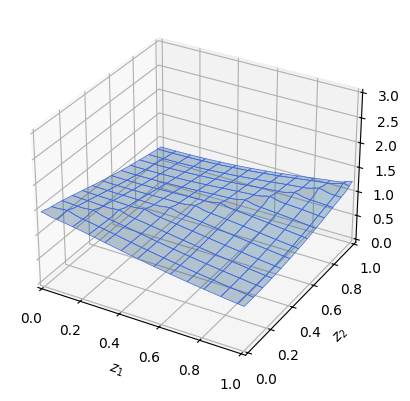

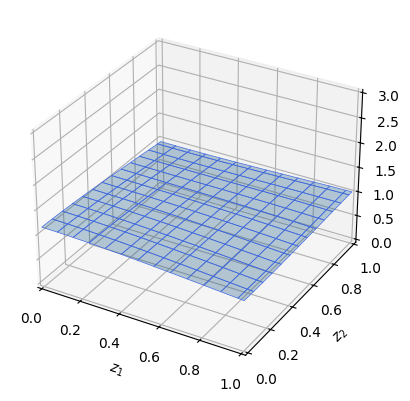

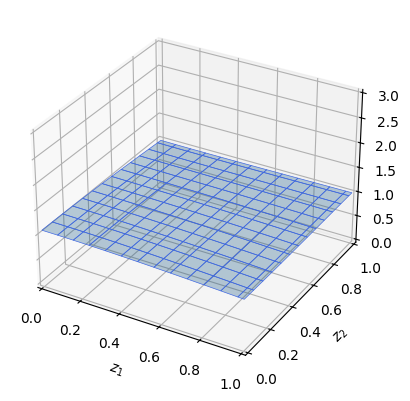

In [6]:


for eta in [1,2,3]: #eta is nu in the paper
    # define the inital state
    rng_key = random.PRNGKey(12345)

    key, rng_key = jax.random.split(rng_key)
    L = numpyro.sample("R",dist.LKJCholesky(DIM,eta, sample_method=sample_method),sample_shape=(N_samples,), rng_key=key)
    R = jax.vmap(lambda L: L@L.T)(L)

    if DIM == 2:
        resolution = 100
        u1 = jnp.linspace(0, 1, resolution)
        u2 = jnp.linspace(0, 1, resolution)
        u1, u2 = jnp.meshgrid(u1, u2)

        def chol_c_G2(u1,u2,L):
            return chol_c_G(jnp.array([u1,u2]),L)
        
        resgrid = jax.vmap(jax.vmap(jax.vmap(chol_c_G2,(0,0,None)),(0,0,None)) , (None,None,0))(u1,u2,L)
        resgrid = jnp.mean(resgrid,0)
        

    else:
        key, rng_key = jax.random.split(rng_key)

        u = random.uniform(key,(N_samples+1,DIM))
        u
    
    if DIM == 2:
       import matplotlib.pyplot as plt

       from mpl_toolkits.mplot3d import axes3d

       ax = plt.figure().add_subplot(projection='3d')

       X, Y, Z = u1,u2,resgrid

       # Plot the 3D surface
       ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                     alpha=0.3)


       ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 3),
              xlabel='$z_1$', ylabel='$z_2$')

       plt.savefig('mutltivariate_calib_eta_{}.pdf'.format(eta), bbox_inches='tight')

       plt.show()